In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model

In [4]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    'data/validate',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')

Found 3219 images belonging to 2 classes.
Found 172 images belonging to 2 classes.


In [5]:
# Load pre-trained MobileNetV2 model + higher level layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print(base_model.input)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor_157>


In [18]:

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for i, layer in enumerate(base_model.layers):
    # layer.trainable = i > len(base_model.layers) - 15  # Train last 15
    layer.trainable = False
    print(i, 'trainable' if layer.trainable else 'not trainable', layer)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Class weights to handle imbalance
class_weights = {0: 1.0, 1: 14.1236842105}

# # Train the model
hist = model.fit(train_generator, epochs=4, validation_data=validation_generator, class_weight=class_weights)

0 not trainable <InputLayer name=input_layer_1, built=True>
1 not trainable <Conv2D name=Conv1, built=True>
2 not trainable <BatchNormalization name=bn_Conv1, built=True>
3 not trainable <ReLU name=Conv1_relu, built=True>
4 not trainable <DepthwiseConv2D name=expanded_conv_depthwise, built=True>
5 not trainable <BatchNormalization name=expanded_conv_depthwise_BN, built=True>
6 not trainable <ReLU name=expanded_conv_depthwise_relu, built=True>
7 not trainable <Conv2D name=expanded_conv_project, built=True>
8 not trainable <BatchNormalization name=expanded_conv_project_BN, built=True>
9 not trainable <Conv2D name=block_1_expand, built=True>
10 not trainable <BatchNormalization name=block_1_expand_BN, built=True>
11 not trainable <ReLU name=block_1_expand_relu, built=True>
12 not trainable <ZeroPadding2D name=block_1_pad, built=True>
13 not trainable <DepthwiseConv2D name=block_1_depthwise, built=True>
14 not trainable <BatchNormalization name=block_1_depthwise_BN, built=True>
15 not trai

Epoch 1/4
101/101 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9390 - loss: 1.5799 - val_accuracy: 0.9709 - val_loss: 0.1836
Epoch 2/4
101/101 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.9703 - loss: 0.5368 - val_accuracy: 0.9884 - val_loss: 0.0558
Epoch 3/4
101/101 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9803 - loss: 0.1760 - val_accuracy: 0.9360 - val_loss: 0.8444
Epoch 4/4
101/101 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9617 - loss: 0.7654 - val_accuracy: 0.9709 - val_loss: 0.1510


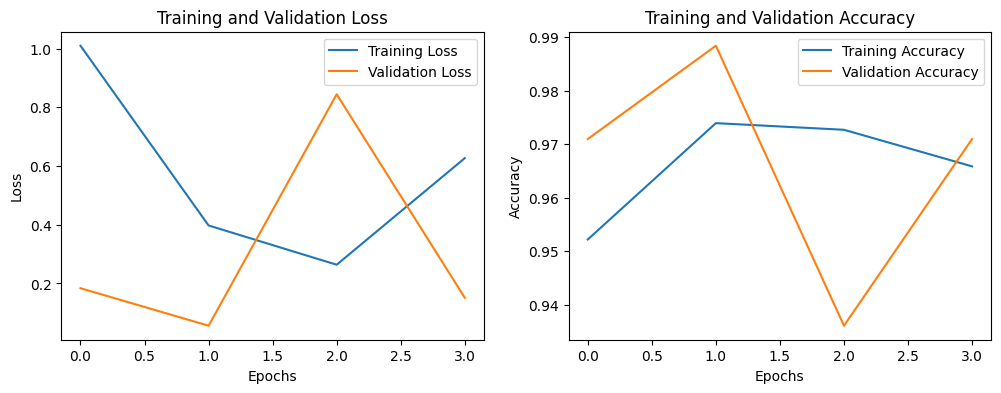

In [19]:
import matplotlib.pyplot as plt

# Extracting data from the history object
training_loss = hist.history['loss']
validation_loss = hist.history['val_loss']
training_accuracy = hist.history['accuracy']
validation_accuracy = hist.history['val_accuracy']

# Plotting the training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [22]:
# model.save('training3.h5')
model.export('training4')

INFO:tensorflow:Assets written to: training4\assets


INFO:tensorflow:Assets written to: training4\assets


Saved artifact at 'training4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_157')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2423475999120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2423476000656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2423476000848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2423476000464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2423475998928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2423476001232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2423476002576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2423476002768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2423476002384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2423476001616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2423476003152: TensorSpec(shape=(), d

In [18]:
# model = load_model('training1.h5')  # accuracy: 0.9834 - loss: 0.0587
# model = load_model('training2.h5')  # accuracy: 0.9747 - loss: 0.1484
model = load_model('training3.h5')  # accuracy: 0.9875 - loss: 0.0495

# Evaluate the model
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

model.evaluate(test_generator)

Found 862 images belonging to 2 classes.
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 948ms/step - accuracy: 0.9875 - loss: 0.0495


[0.04365720972418785, 0.988399088382721]

In [17]:
import tensorflowjs as tfjs

c:\Users\Evan Mazor\code\repos\bite-recognition\.venv\Lib\site-packages\tensorflowjs\read_weights.py:28: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.uint8, np.uint16, np.object, np.bool]


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations